**0.Đồ án cuối kì**


Thông tin sinh viên :

1. NGUYỄN VĂN TUẤN - 1512638

2. HUỲNH DUY NHẬT QUANG - 1312457

https://gitlab.com/snoobvn/dack-ltss

In [22]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

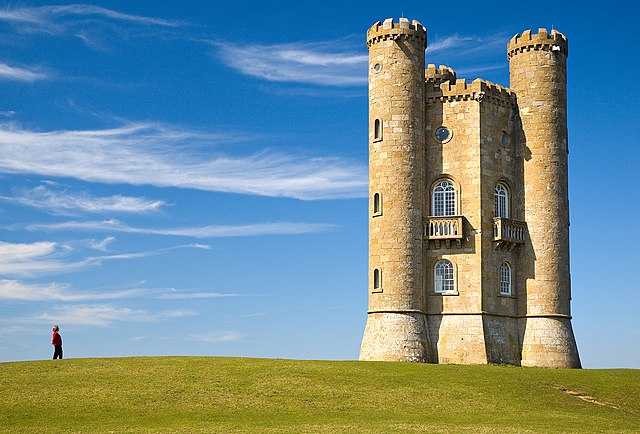

In [31]:
show_pnm("14_15-In.pnm")

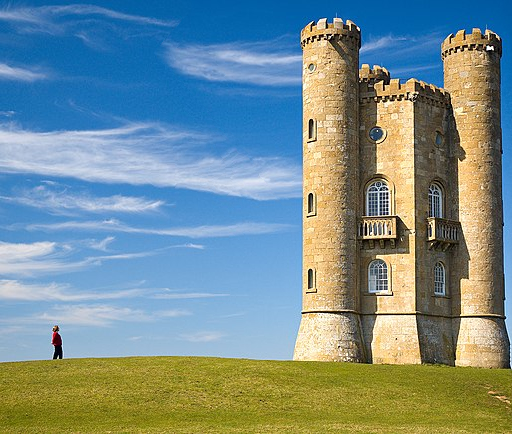

In [36]:
show_pnm("out_host.pnm")

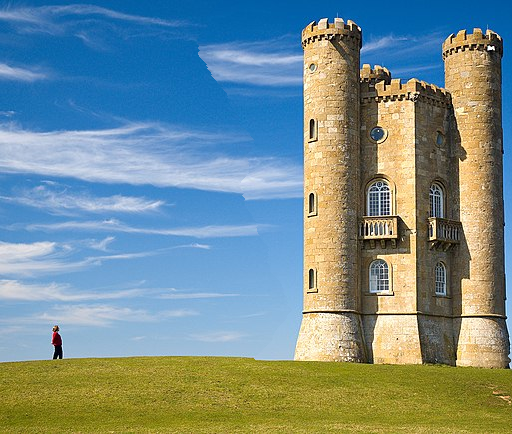

In [50]:
show_pnm("out_device.pnm")

**1. Mô tả ứng dụng**

Thay đổi kích thước ảnh bằng phương pháp "seam carving"
- Input: Ảnh RBG định dạng pnm cần resize
- Output: Ảnh RBG sau khi đã resize (không làm biến dạng các đối tượng quan trọng)
- Đồ án này chỉ thu hẹp chiều rộng
- Ý nghĩa thực tế: Resize ảnh với các kích thướng khác nhau mà không ảnh hưởng quá nhiều đến nội dung
- Ứng dụng này cần tăng tốc vì cài đặt tuần tự rất chậm



**2 Cài đặt tuần tự:**

**Ý tưởng cụ thể:**
1. Tìm độ quan trọng của mỗi pixel
2. Tìm seam ít quan trọng nhất từ độ quan trọng của pixel
3. Xóa seam này
4. Lặp lại cho đến khi có được kích thước cần thiết

**Tìm độ quan trọng (energy) của mỗi pixel:**
1. Chuyển ảnh RBG sang ảnh grayscale
2. Thực hiện convolution theo chiều x với bộ lọc x-Sobel
3. Thực hiện convolution theo chiều y với bộ lọc y-Sobel
4. Độ quan trọng = abs(x) + abs(y)



In [5]:
env FINAL_WIDTH = 512

env: FINAL_WIDTH=512


In [90]:
!nvcc main_host.cu -o main_host && ./main_host 14_15-In.pnm out $FINAL_WIDTH

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434

FinalWidth Width : 512.000000

Processing time (use host): 4260.706543 ms



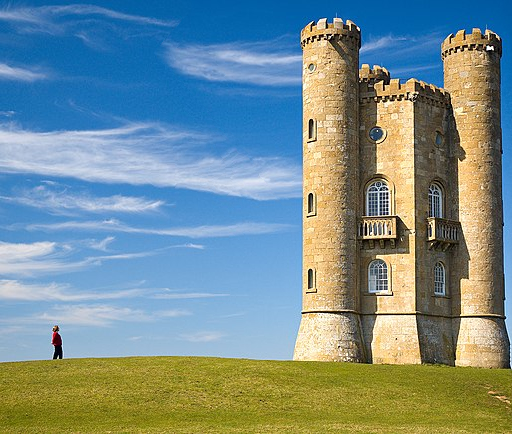

In [49]:
show_pnm("out_host.pnm")

**3.Cài đặt song song**
1. Phân tích
Có thể song song hóa ở các bước:
- Chuyển ảnh sang Gray(convertRgb2GrayKernel)
- Tính độ quan trọng của pixel (computeEnergyKernel)
- Dịch pixel (Hàm xoaSeam)
2. Thiết kế
3. Kết quả:
+ Thời gian thực thi: 
 - Chuyển ảnh sang Gray: 0 đáng kể
 - Tính độ quan trọng của pixel: Giảm đi 20 lần so với host

**Attempt 1: Thực hiện chuyển grayscale trên kernel rồi copy lại**

In [24]:
!nvcc main_grayscale.cu -o main_grayscale && ./main_grayscale 14_15-In.pnm out $FINAL_WIDTH

gcc: error: main_grayscale.cu: No such file or directory
gcc: warning: ‘-x c++’ after last input file has no effect
gcc: fatal error: no input files
compilation terminated.


**Kết luận: Tốc độ không khác bao nhiêu**

**Attempt 2: Thực hiện tính tính energy trên kernel rồi copy lại**

In [146]:
!nvcc main_computeKernel.cu -o main_computeKernel && ./main_computeKernel 14_15-In.pnm out $FINAL_WIDTH

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434

FinalWidth Width : 320.000000

Processing time (use host): 9141.456055 ms

Processing time (use device): 1197.687500 ms

Error between device result and host result: 0.000067


Nhận xét: thời gian thực thi giảm 10 lần.
Có tỉ lệ error giữa host và device tạm chấp nhận (0.000067)

**Attempt 3:**
- Trong vòng lặp: (Tìm _lowestEnergyCol kế tiếp -> Dịch pixel -> Di chuyển tới hàng kế tiếp)
Ta có thể song song hóa bằng cách:
- Tìm _lowestEnergyCol kế tiếp 
- Dịch pixel
- Lưu kế quả vào 1 mảng
=> Dịch 1 lượt

In [41]:
!nvcc main_device_move_pixel.cu -o main_device_move_pixel && ./main_device_move_pixel 14_15-In.pnm out $FINAL_WIDTH

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434

FinalWidth Width : 512.000000

Processing time (use host): 4255.461426 ms

Processing time (use device): 646.613892 ms

Error between device result and host result: 9.323253


In [ ]:
Nhận xét: thời gian thực thi giảm 2 lần so với trước đó
Có tỉ lệ error giữa host và device chưa debug được (0.000067)

**4. Tối ưu hóa**

1. Phiên bản 1:
- Phân tích: Sử dụng SMEM trong hàm tính priority
- Thiết kế: Làm tương tự bt03, thay vì tính trực tiếp trên GMEM thì tính trên SMEM
- Đánh giá: (Không tối ưu).

2. Phiên bản 2 (đã làm ngay bước song song):
- Phân tích:Sử dụng CMEM cho filter sobel
- Đánh giá: (Thời gian thực thi).

In [42]:
!nvcc main_device_move_pixel_smem.cu -o main_device_move_pixel_smem && ./main_device_move_pixel_smem 14_15-In.pnm out $FINAL_WIDTH

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434

FinalWidth Width : 512.000000

Processing time (use host): 4271.942871 ms

Processing time (use device): 651.531494 ms

Error between device result and host result: 9.323253


Nhận xét: Tốc độ không có gì thay đổi ???

**5.Nhìn lại quá trình**
- Còn có lỗi giữa host và device chưa khắc phục được
- Có cố gắng sử dụng smem để tối ưu hóa nhưng không cải thiện
- Chưa tận dụng Stream

**6. Tài liệu kham khảo**
- https://github.com/abhandaru/gpu-seamcarving/blob/master/cuda/seamcarver.cu
- https://shwestrick.github.io/2020/07/29/seam-carve.html

- BT1 - Chuyển đổi ảnh Grayscale

- BT3 - blurImg2,3 sử dụng SMEM, GMEM

- Có kham khảo thêm code của 1 số bạn trong lớp